# Introduction
This is my first attempt at exploring the data for the Redi 2025 summer Data Circle. The project is Pump it Up: Data Mining the Water Table, the information for which one can find [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/). All mistakes are my own.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd # geospatial data processing
import matplotlib.pyplot as plt # standard plotting packages
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# I am running these on Kaggle, because my computer and I are fighting. Feel free to set your own path
path = '~/coding/water_pumps/Data/'
# Reading the files
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
labels = pd.read_csv(path+'train_labels.csv')
# final submission file to be added later
print('done')

done


# Initial exploring, missing values

In [2]:
# Format number display, show all columns
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 55)
print("Size = ",train.shape)
print("Labels = ", labels.head())
print(train.head(10))
# print(train.info())
print(train.describe().T)

Size =  (59400, 40)
Labels =        id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional
      id  amount_tsh date_recorded               funder  gps_height  \
0  69572    6,000.00    2011-03-14                Roman        1390   
1   8776        0.00    2013-03-06              Grumeti        1399   
2  34310       25.00    2013-02-25         Lottery Club         686   
3  67743        0.00    2013-01-28               Unicef         263   
4  19728        0.00    2011-07-13          Action In A           0   
5   9944       20.00    2011-03-13  Mkinga Distric Coun           0   
6  19816        0.00    2012-10-01                 Dwsp           0   
7  54551        0.00    2012-10-09                Rwssp           0   
8  53934        0.00    2012-11-03             Wateraid           0   
9  46144        0.00    2011-08-03          Isingiro Ho           0   

      installer  longitude  latitude  

## First impressions
The qualitative data seem to repeat, particularly in variables ending with `_group`. This means that we have less data than I originally though. However, the geo data should allow us to include external data on weather, population density, economic activity, etc. Some missing values also seem to be coded as 0 (average year is *not* 1300).

From a data transformation standpoint, there are few quantitative variables. Really, only `amount_tsh` (available amount), `gps_height`, `population`, and `construction_year` jump out to me, with possible help from `num_private` (although it seems to be mostly 0). Hopefully the categorical data will prove useful.

In [3]:
# regular missing values
nan_first = train.isnull().sum().sort_values(ascending=False)*100/len(train)
print("~~~ Percent missing values: \n", nan_first.map("{:,.2f}%".format))
print("~~~ Unique values:\n",train.nunique().sort_values(ascending=False)) 

~~~ Percent missing values: 
 scheme_name              48.50%
scheme_management         6.53%
installer                 6.15%
funder                    6.12%
public_meeting            5.61%
permit                    5.14%
subvillage                0.62%
wpt_name                  0.00%
payment                   0.00%
waterpoint_type           0.00%
extraction_type_group     0.00%
extraction_type_class     0.00%
source_class              0.00%
management                0.00%
management_group          0.00%
source_type               0.00%
source                    0.00%
water_quality             0.00%
quality_group             0.00%
extraction_type           0.00%
quantity                  0.00%
quantity_group            0.00%
payment_type              0.00%
id                        0.00%
construction_year         0.00%
amount_tsh                0.00%
recorded_by               0.00%
population                0.00%
ward                      0.00%
lga                       0.00%
district_c

In [4]:
# Setting 0 to NaN in most numerical variables
train['amount_tsh'] = train['amount_tsh'].replace(0, np.NaN)
train['gps_height'] = train['gps_height'].replace(0, np.NaN)
train['longitude'] = train['longitude'].replace(0, np.NaN)
train['latitude'] = train['latitude'].where(train['latitude'] < -0.5, np.NaN) # too close to the equator
# train['population'] = train['population'].replace(0, np.NaN)  ## I worry here that 0 may be true 0, making a histogram
train['construction_year'] = train['construction_year'].replace(0, np.NaN) 
# num_private also ignored because I don't know what it means yet
# print again
nan_fixed = train.isnull().sum().sort_values(ascending=False)*100/len(train)
diffs = (nan_fixed - nan_first)
print("~~~ Differences: \n", diffs[diffs>0].map("{:,.1f}%".format)) 
print("~~~ New percent missing values: \n",nan_fixed[nan_fixed>0].map("{:,.3f}%".format))

~~~ Differences: 
 amount_tsh           70.1%
construction_year    34.9%
gps_height           34.4%
latitude              3.1%
longitude             3.1%
dtype: object
~~~ New percent missing values: 
 amount_tsh           70.099%
scheme_name          48.502%
construction_year    34.864%
gps_height           34.407%
scheme_management     6.529%
installer             6.153%
funder                6.123%
public_meeting        5.613%
permit                5.145%
longitude             3.051%
latitude              3.051%
subvillage            0.625%
wpt_name              0.003%
dtype: object


## Missing Values summary
Missing values are significant, particularly in `amount_tsh` *the total static head* (amount water available to waterpoint). I'm less worried about the half missing scheme names, more about the third construction year. GPS height we can probably get from the geo data. After the initial analysis, we're going to figure out if any of these are missing not at random.

Also, after realizing that no latitude values were set as 0, I used -0.5 as a cutoff, which matches the number of changed cells as the longitude values.

# Unique Values

In [5]:
# Showing unique values for selected variables, probably too many but hey, pixles are cheap
temp = train[['quantity','quantity_group','management','scheme_management','management_group','water_quality','quality_group','waterpoint_type','waterpoint_type_group','payment_type','payment','basin','source','source_class','source_type','extraction_type','extraction_type_class','extraction_type_group','region','region_code','public_meeting','permit']]
for col in temp.columns:
    print("~~~~~~~~~~~~~~~~")
    print(temp[col].value_counts().map("{:,.0f}".format).to_string())

~~~~~~~~~~~~~~~~
quantity
enough          33,186
insufficient    15,129
dry              6,246
seasonal         4,050
unknown            789
~~~~~~~~~~~~~~~~
quantity_group
enough          33,186
insufficient    15,129
dry              6,246
seasonal         4,050
unknown            789
~~~~~~~~~~~~~~~~
management
vwc                 40,507
wug                  6,515
water board          2,933
wua                  2,535
private operator     1,971
parastatal           1,768
water authority        904
other                  844
company                685
unknown                561
other - school          99
trust                   78
~~~~~~~~~~~~~~~~
scheme_management
VWC                 36,793
WUG                  5,206
Water authority      3,153
WUA                  2,883
Water Board          2,748
Parastatal           1,680
Private operator     1,063
Company              1,061
Other                  766
SWC                     97
Trust                   72
~~~~~~~~~~~~~~~~
management_

## Unique values observations
* `quantity` and `quantity_group` have the same number of observations, probably can drop one
* `management` has more info than `management_group`, but still 40k observations for vwc. `scheme_management` seems not to add much, plus has more missing values. Make a dummy variable `vwc` and drop the rest?
* `water_quality` is also mostly the same, quality group very similar
* `waterpoint_type` brings more, but `waterpoint_type_group` is just that, with the two communal standpipes added
* `payment` looks promising, with the respective `_type` simply being the same counts. Drop (unless counts are the same but obs are different)
* `basin`, `region` could feed into our geospatial analysis. I actually like `basin` better because it correlates more closely with the weather aspect and would be more useful in a model with rainfall, for example.
* `source` could also help with a geospatial model using weather. For the overall model, `source_class` is more succinct, binary plus 278 "unknown" (missing values). `source_type` adds other & unknown, hand & machine dtw (down the well?). river & lake.
* The extraction variables are half based on gravity. `extraction_type_class` is the most general, but I think that deciding this will require some domain-specific research.
* We know from earlier that `region_code` has 27 unique values, `region` has 21, and `district_code` 20. This is more granular than the 9 basins, but seems inconsistent. Other geographical options are `lga` (125 unique values), `ward (2092), and subvillage (19287(!)). Decisions, decisions...
* `public_meeting` and `permit` are binary. The former is mostly true, might not be useful. But only about 2/3 of pumps have permits, which may be helpful (although 5% missing values). 

# Getting into Spatial Analysis
Here I'm out of my element, happy for any tips at all. First, we'll try a map.

/tmp/ipykernel_7508/1138359844.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/usr/lib/python3/dist-packages/geopandas/geodataframe.py:206: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


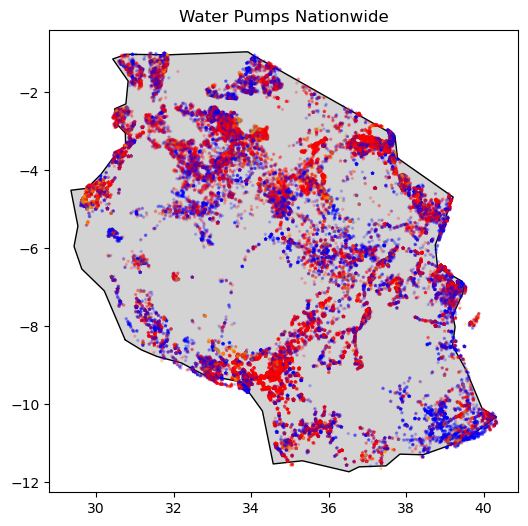

In [6]:
# First, adding the status to the data frame (no leakage because they told us to graph like this?)
train = pd.merge(train, labels, on='id')
# load into geo df
gdf = gpd.GeoDataFrame(
    train, geometry=gpd.points_from_xy(train.longitude, train.latitude), crs="EPSG:4326"
)

# import the necessary packages
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
 
#border.to_crs(epsg=27701).plot(ax=ax, color='lightgrey') ## figure out .to_crs meaning??

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
tanz = world.loc[world['name'] == 'Tanzania']
border = tanz['geometry']
gdf.border = border
# gdf = gdf.set_index('region_code')

# create an Axes object and plot the map
# fig, ax = plt.subplots(figsize=(8,8))
# gdf.plot(ax=ax, color='purple', alpha=0.1)#, cmap='PRGn')
cmap, norm = mcolors.from_levels_and_colors([0, 2, 5, 6], ['red', 'orange', 'blue'])
fig, ax = plt.subplots(figsize = (8,6))
border.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='k')
gdf.plot(column='status_group', cmap=cmap, marker='*', markersize=3, ax=ax, alpha=0.2)

ax.set_title('Water Pumps Nationwide')

plt.savefig('tanz.png')